# Phase III

In [1]:
import gurobipy as grb
import pandas as pd
import sklearn.cluster
import grpcio

In [2]:
data = pd.read_csv('Phase2_Data_raw.csv')

In [3]:
data['full_name'] = data.name + "-" + data['parent-location']

In [4]:
data.head()

,Unnamed: 0,Unnamed: 0.1,GEOID,year,name,parent-location,population,poverty-rate,pct-renter-occupied,median-gross-rent,...,pct-other,renter-occupied-households,eviction-filings,evictions,eviction-rate,eviction-filing-rate,low-flag,imputed,subbed,full_name
0,0,17,1001,2000,Autauga County,Alabama,43671,10.92,19.21,537.0,...,0.10,3074,61.0,40.0,1.30,1.98,0,0,1,Autauga County-Alabama
1,1,18,1003,2000,Baldwin County,Alabama,140415,10.15,20.46,566.0,...,0.07,11320,213.0,65.0,0.57,1.88,0,0,1,Baldwin County-Alabama
2,2,19,1005,2000,Barbour County,Alabama,29038,26.80,26.87,333.0,...,0.01,2797,15.0,11.0,0.39,0.54,0,0,0,Barbour County-Alabama
3,3,20,1007,2000,Bibb County,Alabama,20826,20.61,19.81,348.0,...,0.00,1470,13.0,8.0,0.54,0.88,0,0,0,Bibb County-Alabama
4,4,21,1009,2000,Blount County,Alabama,51024,11.74,16.56,385.0,...,0.03,3190,NaN,NaN,NaN,NaN,0,0,0,Blount County-Alabama


In [5]:
data_used = data[data.year==data.year.max()]

In [6]:
data_used = data_used[['full_name','name','parent-location','GEOID','eviction-rate','rent-burden','poverty-rate','pct-renter-occupied']]

In [7]:
data_used.head()

,full_name,name,parent-location,GEOID,eviction-rate,rent-burden,poverty-rate,pct-renter-occupied
1072,Autauga County-Alabama,Autauga County,Alabama,1001,2.16,32.8,9.28,26.08
1073,Baldwin County-Alabama,Baldwin County,Alabama,1003,2.11,30.3,9.63,28.48
1074,Barbour County-Alabama,Barbour County,Alabama,1005,0.63,30.3,19.54,36.41
1075,Bibb County-Alabama,Bibb County,Alabama,1007,0.86,26.9,12.84,24.89
1076,Blount County-Alabama,Blount County,Alabama,1009,1.03,26.1,12.26,21.10


In [8]:
data_used.head()

,full_name,name,parent-location,GEOID,eviction-rate,rent-burden,poverty-rate,pct-renter-occupied
1072,Autauga County-Alabama,Autauga County,Alabama,1001,2.16,32.8,9.28,26.08
1073,Baldwin County-Alabama,Baldwin County,Alabama,1003,2.11,30.3,9.63,28.48
1074,Barbour County-Alabama,Barbour County,Alabama,1005,0.63,30.3,19.54,36.41
1075,Bibb County-Alabama,Bibb County,Alabama,1007,0.86,26.9,12.84,24.89
1076,Blount County-Alabama,Blount County,Alabama,1009,1.03,26.1,12.26,21.10


In [9]:
data_used[data_used['poverty-rate']==data_used['poverty-rate'].max()]

,full_name,name,parent-location,GEOID,eviction-rate,rent-burden,poverty-rate,pct-renter-occupied
39164,Shannon County-South Dakota,Shannon County,South Dakota,46113,NaN,19.3,45.38,47.32


In [10]:
data_used = data_used.fillna(0)

# Clustering Analysis

In [11]:
# i'm not sure if I actually want/need to do this

In [12]:
cluster = sklearn.cluster.KMeans(n_clusters=3).fit(data_used[['rent-burden','poverty-rate','pct-renter-occupied']]).predict(data_used[['rent-burden','poverty-rate','pct-renter-occupied']])

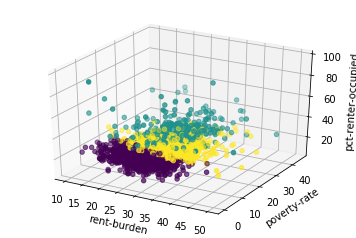

In [13]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def randrange(n, vmin, vmax):
    '''
    Helper function to make an array of random numbers having shape (n, )
    with each number distributed Uniform(vmin, vmax).
    '''
    return (vmax - vmin)*np.random.rand(n) + vmin

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

n = 100

# For each set of style and range settings, plot n random points in the box
# defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
#for c, m, zlow, zhigh in [('r', 'o', -50, -25), ('b', '^', -30, -5)]:
xs = data_used['rent-burden']
ys = data_used['poverty-rate']
zs = data_used['pct-renter-occupied']
ax.scatter(xs, ys, zs,c=cluster)

ax.set_xlabel('rent-burden')
ax.set_ylabel('poverty-rate')
ax.set_zlabel('pct-renter-occupied')

plt.show()

# Funding allocation model

In [14]:
data = data_used

In [15]:
counties = data.full_name.unique()

In [16]:
policyTypes = ['poverty-rate','rent-burden','pct-renter-occupied']

In [17]:
curEvic = data[['full_name','eviction-rate']]

In [18]:
budget = 1000

In [19]:
slope = {'poverty-rate':1/2,'rent-burden':1/3,'pct-renter-occupied':1/4}

In [20]:
maxProgramSize = {'poverty-rate':budget*.3,'rent-burden':budget*.3,'pct-renter-occupied':budget*.4}

### Decision variables

In [21]:
m = None
m = grb.Model('policyDecisions')

In [22]:
funding = m.addVars(counties,policyTypes,lb=0.0, vtype=grb.GRB.CONTINUOUS)

In [23]:
redEvic = m.addVars(counties,lb=0.0,vtype=grb.GRB.CONTINUOUS)

In [24]:
newEvic = m.addVars(counties,lb=0.0,vtype=grb.GRB.CONTINUOUS)

In [25]:
#countyAddressed = m.addVars(counties,vtype=grb.GRB.BINARY)

### Objective(s)

In [26]:
m.setObjective(grb.quicksum(newEvic[c] for c in counties)/len(counties),grb.GRB.MINIMIZE)

### Constraints

In [27]:
#m.remove(lbAvg) #remove a constraint

In [28]:
makeAnImpact = m.addConstrs((redEvic[c] == grb.quicksum(slope[p]*funding[c,p] for p in policyTypes ) for c in counties ),'makeAnImpact')

In [29]:
getNewEvictionRate = m.addConstrs((newEvic[c] == curEvic['eviction-rate'][curEvic.full_name==c].iloc[0]-curEvic['eviction-rate'][curEvic.full_name==c].iloc[0]*redEvic[c]/100 for c in counties),'getNewEvictionRate')

In [30]:
limitTotalSpending = m.addConstr((grb.quicksum(funding[c,p] for c in counties for p in policyTypes)<=budget),'limitSpending')

In [31]:
limitProgramSpending = m.addConstrs((grb.quicksum(funding[c,p] for c in counties)<=maxProgramSize[p] for p in policyTypes),'limitSpending')

In [32]:
#ifFundedAddressed = m.addConstrs((grb.quicksum(funding[c,p] for p in policyTypes)>=countyAddressed[c] for c in counties),'ifFundedAddressed')

In [33]:
#lbZero = m.addGenConstrIndicator(countyAddressed[c],1,newEvic[c],sense=grb.GRB.GREATER_EQUAL,rhs=data['eviction-rate'].mean())

In [34]:
#lbAvg = m.addConstrs((newEvic[c] >= data['eviction-rate'].mean() for c in counties),'lbAvg')

### Output

In [35]:
#m.params.DualReductions = 0

In [36]:
m.write('formulation.lp')

In [37]:
try:
    m.computeIIS()
    m.write('problem.ilp')
except:
    None

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0   0.0000000e+000  2.122000e+005  0.000000e+000      0s
IIS runtime: 0.21 seconds


In [38]:
m

<gurobi.Model Continuous instance policyDecisions: 6288 constrs, 15710 vars, Parameter changes: LogFile=gurobi.log>

In [39]:
m.optimize()
print(m.getAttr('Status'))

Optimize a model with 6288 rows, 15710 columns and 36684 nonzeros
Coefficient statistics:
  Matrix range     [1e-04, 1e+00]
  Objective range  [3e-04, 3e-04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e-02, 1e+03]

Solved in 2591 iterations and 0.02 seconds
Optimal objective  1.245482177e+00
2


In [40]:
print('original avg eviction rate: ',round(data['eviction-rate'].mean(),2),'%')
print('new avg eviction rate: ',round(m.getObjective().getValue(),2),'%')
print('impact on eviction rate: ',round(data['eviction-rate'].mean()-m.getObjective().getValue(),2),'%')

original avg eviction rate:  1.26 %
new avg eviction rate:  1.25 %
impact on eviction rate:  0.02 %


In [41]:
for c in counties:
    for p in policyTypes:
        if funding[c,p].x>0:
            print(c,p,curEvic['eviction-rate'][curEvic.full_name==c].iloc[0],redEvic[c].x,newEvic[c].x,'$',funding[c,p].x)

Cherokee County-South Carolina poverty-rate 16.41 100.0 0.0 $ 200.0
Florence County-South Carolina poverty-rate 16.13 50.0 8.065 $ 100.0
Hopewell city-Virginia rent-burden 15.69 100.0 0.0 $ 300.0
Petersburg city-Virginia pct-renter-occupied 17.56 100.0 0.0 $ 400.0


In [45]:
r = [5.0,10.0,15.0]
sum(r)

30.0